In [195]:
#import libraries 25/02/23
import pandas as pd
import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#from matplotlib import offsetbox
#import matplotlib.patheffects as PathEffects
#from pydiffmap import diffusion_map as dm
#import seaborn as sns
from sklearn.metrics import euclidean_distances
from numpy import loadtxt
from imblearn.keras import BalancedBatchGenerator

#from imblearn.under_sampling import NearMiss
#import keras
from keras import metrics
from imblearn.keras import BalancedBatchGenerator
from keras.models import Sequential
#import keras.metrics
import sklearn.metrics
from keras.layers import Dense
#from pydiffmap.visualization import embedding_plot, data_plot
#sns.set()
import math
#from stg import STG
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import SGDClassifierp
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
#from itertools import product
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import confusion_matrix
#from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os
#import pyrfm
#from scipy import stats
#import xgboost
#from xgboost import XGBClassifier
from sklearn.utils import class_weight
#from catboost import CatBoostClassifier
#from collections import OrderedDict
#from functools import partial
from time import time
import matplotlib.pyplot as pyplot
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.ticker import NullFormatter
#from sklearn import manifold, datasets
#from sklearn.decomposition import PCA

In [6]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd

In [162]:
#import file
os.chdir("/Users/glrz/Desktop/Thesis/data_files")
file = "file for osnat 22.06.20.csv"
df = pd.read_csv(file, sep = ',')
df.head()
#description = df.describe()
#print(df['cancergrp'].value_counts())
# mapping outcome to cancer/no-cancer groups
mapping = { 1: 0, 2: 0, 3: 1}
df['outcome'] = df['outcome'].map(mapping)

In [163]:
df.columns

Index(['sid', 'days', 'tshresult', 'ft3result', 'ft4result', 'tt3result',
       'tt4result', 'outcome', 'gender', 'age', 'hypertension', 'dyslipidemia',
       'diabetes', 'IHD', 'CHF', 'CVA_TIA', 'CRF', 'chroniclung',
       'chronicliver', 'BMI', 'hyperthyroid', 'hyperdays', 'hypothyroid',
       'hypodays', 'cancergrp', 'autoanti', 'autoantidays', 'hyperdrugdays',
       'hyperdrugcnt', 'hypodrugdays', 'hypodrugcnt', 'smoking', 'smokingdays',
       'Ethnicity', 'SES'],
      dtype='object')

In [164]:
#preprocessing - missing values & normalization 
#mapping only thyroid cancer 1k observations out of 30 types of cancer
df["cancergrp"] = pd.to_numeric(df["cancergrp"])
#top 5 cancer groups
df.loc[df['cancergrp'] == 10, 'outcome'] = 10 #4024 observations
df.loc[df['cancergrp'] == 4, 'outcome'] = 4 #3094 observations
df.loc[df['cancergrp'] == 14, 'outcome'] = 14 #2406 observations
df.loc[df['cancergrp'] == 7, 'outcome'] = 7 #1955 observations
df.loc[df['cancergrp'] == 16, 'outcome'] = 16 #1354
df.loc[df['cancergrp'] == 18, 'outcome'] = 18 #886
#other cancer types will remain 1 and 0 for no cancer

# filling missing values
df['Ethnicity'] = df['Ethnicity'].fillna(1)

s = df['SES'].value_counts(normalize=True)
missing = df['SES'].isnull()
df.loc[missing,'SES'] = np.random.choice(s.index, size = len(df[missing]), p = s.values)

df['hypodays'] = df['hypodays'].fillna(value = 0) #have a flag for missing
df['hyperdays'] = df['hyperdays'].fillna(value = 0) #have a flag for missing
#flags for hypo and hyper drug, and ft availability
missing = df['hypodrugdays'].isnull()
df.loc[missing,'hypodrug_flag'] = 0
df['hypodrug_flag'] = df['hypodrug_flag'].fillna(value = 1)
missing = df['hyperdrugdays'].isnull()
df.loc[missing,'hyperdrug_flag'] = 0
df['hyperdrug_flag'] = df['hyperdrug_flag'].fillna(value = 1)
missing = df['ft3result'].isnull()
df.loc[missing,'ft3_flag'] = 0
df['ft3_flag'] = df['ft3_flag'].fillna(value = 1)
missing = df['ft4result'].isnull()
df.loc[missing,'ft4_flag'] = 0
df['ft4_flag'] = df['ft4_flag'].fillna(value = 1)
missing = df['tt3result'].isnull()
df.loc[missing,'tt3_flag'] = 0
df['tt3_flag'] = df['tt3_flag'].fillna(value = 1)
missing = df['tt4result'].isnull()
df.loc[missing,'tt4_flag'] = 0
df['tt4_flag'] = df['tt4_flag'].fillna(value = 1)
#
df['hypodrugdays'] = df['hypodrugdays'].fillna(value = 0)
df['hyperdrugdays'] = df['hyperdrugdays'].fillna(value = 0)
df['hypodrugcnt'] = df['hypodrugcnt'].fillna(value = 0)
df['hyperdrugcnt'] = df['hyperdrugcnt'].fillna(value = 0)
df['autoantidays'] = df['autoantidays'].fillna(value = 0) #have a flag for missing
df['smokingdays'] = df['smokingdays'].fillna(value = 0) #have a flag for missing

# one hot encoding
df = pd.get_dummies(df, columns=['gender','smoking', 'Ethnicity'])
df = df.rename(columns={"gender_1": "is_female", "gender_2": "is_male",
                         "smoking_0": "is_not_smoking", "smoking_1": "is_smoking", "smoking_2": "is_former_smoker",
                         "Ethnicity_1.0": "is_jewish", "Ethnicity_2.0": "is_muslim", "Ethnicity_3.0": "is_other"})
df = df.drop(['is_male','is_not_smoking', 'is_other'], 1) # remove the complementary column to avoid dependency between columns

# BMI imputation with linear regression
df_adj = df.drop(['ft4result', 'ft3result','tt4result','tt3result', 'outcome','days','cancergrp', 'sid'], 1)
df_train = df_adj[df_adj['BMI'].notna()]
df_test = df_adj[df_adj['BMI'].isna()]
y_train = df_train['BMI']
x_train = df_train.drop(['BMI'], 1)
x_test = df_test.drop(['BMI'], 1)
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
df.loc[df['BMI'].isnull(), 'BMI'] = y_pred
df['ft3result'] = df['ft3result'].fillna(value = df['ft3result'].median())
df['ft4result'] = df['ft4result'].fillna(value = df['ft4result'].median())
df['tt3result'] = df['tt3result'].fillna(value = df['tt3result'].median())
df['tt4result'] = df['tt4result'].fillna(value = df['tt4result'].median())

df["age"] = pd.to_numeric(df["age"])

# min max normallization
df_norm = df.drop(['cancergrp','sid','outcome'], 1)
x1 = df_norm.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x1)
df_norm = pd.DataFrame(x_scaled, columns=df_norm.columns)
df_norm['outcome'] =df['outcome']

/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3764756205.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['is_male','is_not_smoking', 'is_other'], 1) # remove the complementary column to avoid dependency between columns
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3764756205.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_adj = df.drop(['ft4result', 'ft3result','tt4result','tt3result', 'outcome','days','cancergrp', 'sid'], 1)
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3764756205.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train = df_train.drop(['BMI'], 1)
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3764756205.py:6

In [165]:
df_norm.columns

Index(['days', 'tshresult', 'ft3result', 'ft4result', 'tt3result', 'tt4result',
       'age', 'hypertension', 'dyslipidemia', 'diabetes', 'IHD', 'CHF',
       'CVA_TIA', 'CRF', 'chroniclung', 'chronicliver', 'BMI', 'hyperthyroid',
       'hyperdays', 'hypothyroid', 'hypodays', 'autoanti', 'autoantidays',
       'hyperdrugdays', 'hyperdrugcnt', 'hypodrugdays', 'hypodrugcnt',
       'smokingdays', 'SES', 'hypodrug_flag', 'hyperdrug_flag', 'ft3_flag',
       'ft4_flag', 'tt3_flag', 'tt4_flag', 'is_female', 'is_smoking',
       'is_former_smoker', 'is_jewish', 'is_muslim', 'outcome'],
      dtype='object')

In [166]:
#creating df per cancer type
df_cancer_10 = df_norm[df_norm['outcome'] == 10]
df_cancer_4 = df_norm[df_norm['outcome'] == 4]
df_cancer_7 = df_norm[df_norm['outcome'] == 7]
df_cancer_16 = df_norm[df_norm['outcome'] == 16]
df_cancer_14 = df_norm[df_norm['outcome'] == 14]
df_cancer_14 = df_cancer_14[df_cancer_14['is_female'] == 0]
df_cancer_18 = df_norm[df_norm['outcome'] == 18]
df_cancer_1 = df_norm[df_norm['outcome'] == 1]
df_no_cancer = df_norm[df_norm['outcome'] == 0]
df_cancer = df_norm[df_norm['outcome'] != 0]
df_cancer.loc[:,'outcome'] = 1

df_cancer_10.loc[:,'outcome']=1
df_cancer_4.loc[:,'outcome']=1
df_cancer_7.loc[:,'outcome']=1
df_cancer_14.loc[:,'outcome']=1
df_cancer_16.loc[:,'outcome']=1
df_cancer_18.loc[:,'outcome']=1
df_cancer_1.loc[:,'outcome']=1
display(df_cancer_18)

/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3750698315.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer.loc[:,'outcome'] = 1
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3750698315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer_10.loc[:,'outcome']=1
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/3750698315.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,days,tshresult,ft3result,ft4result,tt3result,tt4result,age,hypertension,dyslipidemia,diabetes,...,ft3_flag,ft4_flag,tt3_flag,tt4_flag,is_female,is_smoking,is_former_smoker,is_jewish,is_muslim,outcome
215,0.479007,0.001711,0.153846,0.088608,0.131490,0.003284,0.166667,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1
762,0.519533,0.001532,0.153846,0.114768,0.126770,0.003200,0.095238,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
802,0.190946,0.004277,0.153846,0.114768,0.126770,0.003200,0.273810,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
857,0.336802,0.000736,0.153846,0.114768,0.142953,0.003570,0.416667,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1
1151,0.471705,0.003481,0.153846,0.112743,0.138233,0.003453,0.392857,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362173,0.082147,0.003601,0.153846,0.114768,0.126770,0.003200,0.154762,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
364836,0.057503,0.003959,0.146853,0.102110,0.126770,0.003200,0.321429,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
366759,0.008397,0.002964,0.153846,0.114768,0.126770,0.003200,0.488095,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
368885,0.001825,0.004018,0.153846,0.114405,0.126770,0.003200,0.488095,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


# selecting cancer type

In [227]:
#Choose cancer type df to focus
#for all cancer types choose "" for specific x type choose "_x"
cancer_class = "_14"
sel_cancer = globals()["df_cancer"+cancer_class]
if (cancer_class == "14"):
    df_no_cancer = df_no_cancer[df_no_cancer['is_female']==0] 
    sel_cancer = sel_cancer[sel_cancer['is_female']==0] 
#once you run class 14 your dataset is overriden so you need to run from the begining for other cancer types

In [228]:
len(df_no_cancer)

351827

In [229]:
df_no_cancer

,days,tshresult,ft3result,ft4result,tt3result,tt4result,age,hypertension,dyslipidemia,diabetes,...,ft3_flag,ft4_flag,tt3_flag,tt4_flag,is_female,is_smoking,is_former_smoker,is_jewish,is_muslim,outcome
0,1.000000,0.004158,0.153846,0.114768,0.12677,0.003200,0.488095,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1.000000,0.002765,0.153846,0.114768,0.12677,0.003200,0.511905,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,1.000000,0.007937,0.153846,0.114768,0.12677,0.003200,0.583333,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,1.000000,0.002646,0.153846,0.162025,0.12677,0.003200,0.416667,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
6,1.000000,0.006047,0.153846,0.123882,0.11261,0.002813,0.416667,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375630,0.000365,0.005331,0.153846,0.114768,0.12677,0.003200,0.523810,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
375631,0.000365,0.008813,0.153846,0.088608,0.12677,0.003200,0.607143,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
375632,0.000365,0.000696,0.153846,0.135021,0.12677,0.003200,0.761905,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
375633,0.000183,0.003998,0.153846,0.114768,0.12677,0.003200,0.583333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0


# extracting to external files train and test unbalanced

In [230]:
#train test split
train_c, rest_c, = train_test_split(df_no_cancer, test_size=0.15, random_state=42) #split to train -test of cancer
train_n, rest_n = train_test_split(sel_cancer, test_size=0.15, random_state=42) #split to train -test of no cancer
# creating unified test
test = pd.concat([rest_c,rest_n])
train = pd.concat([train_c,train_n])
#os.chdir("data_files")
#train.to_csv('train_u_with_days.csv', encoding='utf-8')
#test.to_csv('test_with_days.csv', encoding='utf-8')

# creating train and test sets for training

In [231]:
#train test split
y_c = sel_cancer['outcome']
X_c = sel_cancer.drop(['outcome'], 1)
y_n = df_no_cancer['outcome']
X_n = df_no_cancer.drop(['outcome'], 1)

X_train_c, X_rest_c, y_train_c, y_rest_c = train_test_split(X_c, y_c, test_size=0.3, random_state=42) #split to train -test of cancer
X_train_n, X_rest_n, y_train_n, y_rest_n = train_test_split(X_n, y_n, test_size=0.3, random_state=42) #split to train -test of no cancer
#validation
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(X_rest_c, y_rest_c, test_size=0.5, random_state=42) #split to train -test of cancer
X_val_n, X_test_n, y_val_n, y_test_n = train_test_split(X_rest_n, y_rest_n, test_size=0.5, random_state=42) #split to train -test of no cancer

# creating unified test & validations
X_test = pd.concat([X_test_c,X_test_n])
y_test = pd.concat([y_test_c,y_test_n])
X_val = pd.concat([X_val_c,X_val_n])
y_val = pd.concat([y_val_c,y_val_n])

#creating balanced train df
X_train_c['outcome']=y_train_c
#sample_n_train=X_train_n.sample(n = X_train_c.shape[0]) #sample of healthy for balance data
# Upsample minority class
df_minority_upsampled = resample(X_train_c, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(y_train_n),    # to match majority class
                                 random_state=42) # reproducible results

y_train_balanced = pd.concat([df_minority_upsampled['outcome'], y_train_n]) #healthy and sick
X_train_balanced = pd.concat([df_minority_upsampled.drop(['outcome'], 1), X_train_n]) #healthy and sick

#creating unbalanced train
X_train_unb=pd.concat([X_train_c.drop(['outcome'], 1),X_train_n])
y_train_unb=pd.concat([y_train_c,y_train_n])
print('shape of train cancer',y_train_balanced.sum())
print('shape of train',y_train_balanced.count())

shape of train cancer 246278
shape of train 492556


/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/545421751.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_c = sel_cancer.drop(['outcome'], 1)
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/545421751.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_n = df_no_cancer.drop(['outcome'], 1)
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/545421751.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_balanced = pd.concat([df_minority_upsampled.drop(['outcome'], 1), X_train_n]) #healthy and sick
/var/folders/06/5gm5cpj53hn_6qgdbf12bqk80000gn/T/ipykernel_6105/545421751.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the ar

In [90]:
#random forest performance
forest = RandomForestClassifier(n_estimators=5000, max_depth=9, random_state=0)
forest.fit(X_train, y_train)
y_rf_train=forest.predict(X_train)
y_rf_val=forest.predict(X_val)
y_rf_test=forest.predict(X_test)

NameError: name 'X_train' is not defined

In [38]:
y_train_score = forest.predict_proba(X_train_balanced)
y_test_score = forest.predict_proba(X_test)
y_val_score = forest.predict_proba(X_val)

/Users/glrz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- outcome
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
tn, fp, fn, tp=confusion_matrix(y_train_balanced, y_rf_train).ravel()
print('no smote rf train',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_val, y_rf_val).ravel()
print('no smote rf val',tn, fp, fn, tp)
#test rf result
tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test, y_rf_test).ravel()
print('no smote rf test',tn_t, fp_t, fn_t, tp_t)
#other method that relates to
#metrics.plot_roc_curve(forest,X_train_balanced, y_train_balanced)
#plt.show()
#metrics.plot_roc_curve(forest,X_test, y_test)
#plt.show()
#auc calculations
print('rf train auc',metrics.roc_auc_score(y_train_balanced,y_train_score[:,1]))
print('rf val auc',metrics.roc_auc_score(y_val,y_val_score[:,1]))
print('rf test auc',metrics.roc_auc_score(y_test,y_test_score[:,1]))

In [46]:
!pip install "tensorflow<2.11"

ERROR: Could not find a version that satisfies the requirement tensorflow<2.11 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1)
ERROR: No matching distribution found for tensorflow<2.11


In [43]:
from platform import python_version

print(python_version())

3.8.16


In [61]:
def get_data(arg1, **kwargs):
    print (arg1, kwargs['arg2'], kwargs['arg3'], kwargs['arg4'])

In [172]:
X_train_b_np = X_train_balanced.to_numpy()
y_train_b_np = y_train_balanced.to_numpy()

In [173]:
# define the keras model
model = Sequential()
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.add(Dense(4, input_dim=X_train_b_np.shape[1], activation='relu'))
#model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics= METRICS)

#under sampling
training_generator = BalancedBatchGenerator(
    X_train_b_np, y_train_b_np, batch_size=32, random_state=42)

# fit the keras model on the dataset using early stoppinng criteria
#set to 12 epochs since validation loss started increasing at epoch 18
history = model.fit(training_generator, validation_data=(X_val, y_val), epochs=13 , batch_size=32, verbose=0, callbacks=[callback])

Epoch 4: early stopping


Train: 0.9374, val: 0.9280, Test: 0.9340
Train prc: 0.9310, val prc: 0.0736, Test prc: 0.0972
Train tp: 212992.0000, fp: 34885.0000, tn: 211393.0000, fn: 33286.0000
validation tp: 169.0000, fp: 7564.0000, tn: 45210.0000, fn: 34.0000
test tp: 177.0000, fp: 7458.0000, tn: 45317.0000, fn: 27.0000


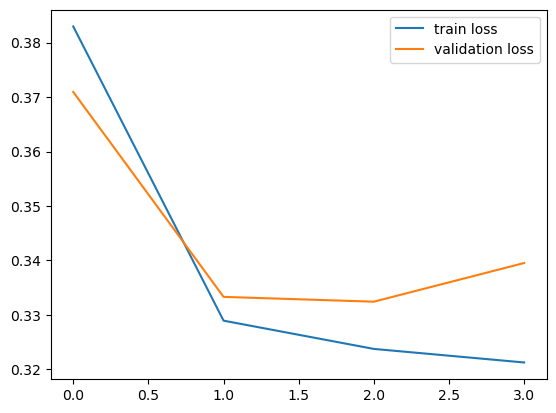

In [174]:
# evaluate the model
t_,t_tp,t_fp,t_tn,t_fn,t_acc,t_precision,t_recall,t_auc,t_prc = model.evaluate(X_train_b_np, y_train_b_np, verbose=0)
test_,test_tp,test_fp,test_tn,test_fn,test_acc,test_precision,test_recall,test_auc,test_prc = model.evaluate(X_test, y_test, verbose=0)
v_,val_tp,val_fp,val_tn,val_fn,val_acc,val_precision,val_recall,val_auc,val_prc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.4f, val: %.4f, Test: %.4f' % (t_auc, val_auc, test_auc))
print('Train prc: %.4f, val prc: %.4f, Test prc: %.4f' % (t_prc, val_prc, test_prc))
print('Train tp: %.4f, fp: %.4f, tn: %.4f, fn: %.4f' % (t_tp, t_fp, t_tn,t_fn))
print('validation tp: %.4f, fp: %.4f, tn: %.4f, fn: %.4f' % (val_tp, val_fp, val_tn, val_fn))
print('test tp: %.4f, fp: %.4f, tn: %.4f, fn: %.4f' % (test_tp, test_fp, test_tn, test_fn))

# plot training history
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

1656/1656 [==============================] - 0s 191us/step


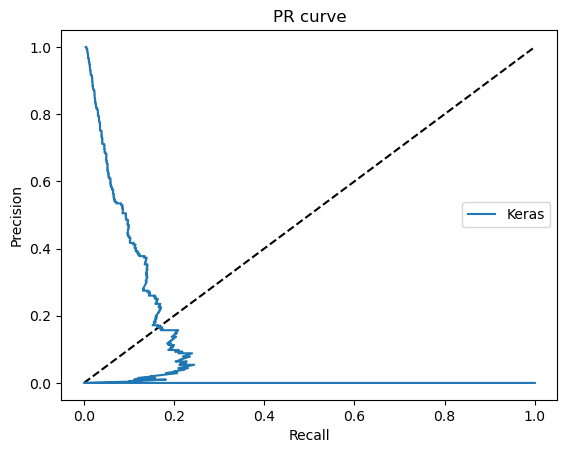

In [175]:
#plot pr curve

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = precision_recall_curve(y_test, y_pred_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()

In [67]:
model.evaluate(X_train_b_np, y_train_b_np, verbose=0)

[0.3822043240070343,
 201988.0,
 38818.0,
 207460.0,
 44290.0,
 0.8312720060348511,
 0.8387997150421143,
 0.8201625943183899,
 0.9103472828865051,
 0.9104652404785156]

In [27]:
import tensorflow

model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Dense(
        12, input_dim=X_train_unb.shape[1], activation='relu'))
model.add(tensorflow.keras.layers.Dense(4, activation='relu'))
model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
#y = tensorflow.keras.utils.to_categorical(y_train_unb)


model.compile(optimizer='sgd', loss='binary_crossentropy',
              metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
    X_train_balanced, y_train_balanced, sampler=NearMiss(), batch_size=100, random_state=42, categorical=False)
callback_history = model.fit(training_generator, epochs=100,batch_size=100, verbose=0)

TypeError: __init__() got an unexpected keyword argument 'categorical'

In [16]:
X_train_unb

,days,tshresult,ft3result,ft4result,tt3result,tt4result,age,hypertension,dyslipidemia,diabetes,...,hyperdrug_flag,ft3_flag,ft4_flag,tt3_flag,tt4_flag,is_female,is_smoking,is_former_smoker,is_jewish,is_muslim
222037,0.048375,0.007619,0.153846,0.114768,0.126770,0.003200,0.642857,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3712,0.396313,0.003760,0.153846,0.099578,0.134862,0.003368,0.488095,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
243107,0.424790,0.001591,0.153846,0.114768,0.126770,0.003200,0.321429,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30728,0.316356,0.019595,0.153846,0.093418,0.152394,0.003806,0.488095,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
111273,0.248083,0.003859,0.153846,0.114768,0.126770,0.003200,0.702381,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133239,0.868383,0.004018,0.153846,0.114768,0.126770,0.003200,0.309524,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
281057,0.510223,0.006246,0.195804,0.157806,0.126770,0.003200,0.035714,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
146303,0.845016,0.007360,0.153846,0.114768,0.126770,0.003200,0.345238,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
162430,0.814896,0.002904,0.153846,0.114768,0.126770,0.003200,0.214286,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# make probability predictions with the model
predict_train = model.predict(X_train_unb)
predict_val = model.predict(X_val)
predict_test = model.predict(X_test)
# round predictions
rounded_train =[round(x[0]) for x in predict_train]
tr=np.asarray(rounded_train)
tr.astype(int)
rounded_val =[round(x[0]) for x in predict_val]
val=np.asarray(rounded_train)
val.astype(int)
rounded_test =[round(x[0]) for x in predict_test]
test=np.asarray(rounded_test)
test.astype(int)

#%%
#table of true,falase
tn, fp, fn, tp=confusion_matrix(y_train_unb, tr).ravel()
print('no smote mlp train',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_val, val).ravel()
print('no smote mlp val',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_test, test).ravel()
print('no smote mlp test',tn, fp, fn, tp)

print('mlp train auc',metrics.roc_auc_score(y_train_balanced,predict_val))
print('mlp val auc',metrics.roc_auc_score(y_val,predict_val))
print('mlp test auc',metrics.roc_auc_score(y_test,predict_test))

In [86]:
###logistic regression
#solver='liblinear',
logis = LogisticRegression(class_weight='balanced')
logis.fit(X_train_unb, y_train_unb)
y_logis_tr = logis.predict(X_train_unb)
y_logis_val = logis.predict(X_val)
y_logis_te=logis.predict(X_test)
#print('y train freq',y_train_unb.value_counts(),'y test freq',y_test.value_counts())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
predict_tr=logis.predict_proba(X_train_unb)[::,1]
predict_val=logis.predict_proba(X_val)[::,1]
predict_test=logis.predict_proba(X_test)[::,1]

In [88]:
print('lo train auc',metrics.roc_auc_score(y_train_unb,predict_tr))
print('lo val auc',metrics.roc_auc_score(y_val,predict_val))
print('lo test auc',metrics.roc_auc_score(y_test,predict_test))
tn, fp, fn, tp=confusion_matrix(y_train_unb, y_logis_tr).ravel()
print('logistic train',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_val, y_logis_val).ravel()
print('logistic val',tn, fp, fn, tp)
#%% #test logistic
tn, fp, fn, tp=confusion_matrix(y_test, y_logis_te).ravel()
print('logistic test',tn, fp, fn, tp)

lo train auc 0.9461126628556644
lo val auc 0.9427936743471845
lo test auc 0.9456577028962483
logistic train 100776 10022 2605 14060
logistic val 21573 2170 576 2995
logistic test 21590 2153 550 3022


In [286]:
#xgboost 
max_depths= [3,4,7]
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_unb
)

# fit model no training data
eval_set = [(X_val, y_val)]
xgmodel = XGBClassifier(verbose=True, max_depth=3)
#xgmodel.fit(X_train_unb, y_train_unb, max_depth=4, early_stopping_rounds=10, eval_set=[(X_val, y_val)], sample_weight=classes_weights)

In [287]:
xgmodel.fit(X_train_unb, y_train_unb, sample_weight=classes_weights)

/Users/glrz/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [288]:
y_pred_train = xgmodel.predict(X_train_unb)
y_pred_val = xgmodel.predict(X_val)
y_pred_test = xgmodel.predict(X_test)

print('xg train auc',metrics.roc_auc_score(y_train_unb,y_pred_train))
print('xg val auc',metrics.roc_auc_score(y_val,y_pred_val))
print('xg test auc',metrics.roc_auc_score(y_test,y_pred_test))
y_p_tr = [round(value) for value in y_pred_train]
y_p_val = [round(value) for value in y_pred_val]
y_p_test = [round(value) for value in y_pred_test]

tn, fp, fn, tp=confusion_matrix(y_train_unb, y_p_tr).ravel()
print('xg train',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_val, y_p_val).ravel()
print('xg val',tn, fp, fn, tp)
#%% #test logistic
tn, fp, fn, tp=confusion_matrix(y_test, y_p_test).ravel()
print('xg test',tn, fp, fn, tp)

xg train auc 0.9233290032633319
xg val auc 0.8056102949271514
xg test auc 0.8056552940041287
xg train 221565 24713 375 6701
xg val 47121 5653 427 1089
xg test 47256 5519 431 1086


In [183]:
#knn

k_values = [2,3,4,5,7,9,11]
scores = []
#Choose optimal K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_unb, y_train_unb, scoring = "f1", cv=5)
    scores.append(np.mean(score))
    print(np.mean(score))

0.2976878350076527


In [ ]:
#The chosen K is 3 for the f1 minimal score

In [184]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_unb, y_train_unb)

KNeighborsClassifier(n_neighbors=3)

In [232]:
# Step 5: Make predictions
y_pred_train = knn.predict(X_train_unb)
y_pred_val = knn.predict(X_val)
y_pred_test = knn.predict(X_test)

In [233]:
# Step 6: Evaluate the accuracy of the model
print('knn train auc',metrics.roc_auc_score(y_train_unb,y_pred_train))
print('knn val auc',metrics.roc_auc_score(y_val,y_pred_val))
print('knn test auc',metrics.roc_auc_score(y_test,y_pred_test))
y_p_tr = [round(value) for value in y_pred_train]
y_p_val = [round(value) for value in y_pred_val]
y_p_test = [round(value) for value in y_pred_test]

tn, fp, fn, tp=confusion_matrix(y_train_unb, y_pred_train).ravel()
print('knn train',tn, fp, fn, tp)
tn, fp, fn, tp=confusion_matrix(y_val, y_pred_val).ravel()
print('knn val',tn, fp, fn, tp)
#%% #test 
tn, fp, fn, tp=confusion_matrix(y_test, y_pred_test).ravel()
print('knn test',tn, fp, fn, tp)

knn train auc 0.7298250847935224
knn val auc 0.7166474362480391
knn test auc 0.7541668952105511
knn train 244238 2040 896 788
knn val 51812 962 198 163
knn test 51826 949 171 190
